# Comparative Model Analysis & Mixture of Experts Potential

This notebook analyzes the per-image IoU results from multiple segmentation models to identify:
1.  **"Easy" vs "Hard" Images**: Which images are universally well-segmented or poorly segmented?
2.  **MoE Potential**: Where do models disagree? If one model fails and another succeeds, a Mixture of Experts (MoE) approach has high potential.
3.  **Per-Class Analysis**: Drill down into specific classes (e.g., "road", "person") to find difficult scenarios.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# --- Step 1: Setup Paths & Load Data ---

# Mount Drive if needed (Colab specific)
try:
    from google.colab import drive
    drive.mount("/content/drive")
    CITYSCAPES_ROOT = Path("/content/drive/MyDrive/UCLA/Datasets/cityscapes")
except ImportError:
    # Local fallback or different path
    CITYSCAPES_ROOT = Path("data/cityscapes") # Update this if running locally without Drive
    print("Not running in Colab, using local path.")

RESULTS_DIR = CITYSCAPES_ROOT / "benchmark_results"

print(f"Looking for results in: {RESULTS_DIR}")

def load_benchmark_results(results_dir: Path) -> pd.DataFrame:
    """
    Loads all *_per_image_iou.csv files from the directory.
    Returns a single DataFrame with a 'model' column.
    """
    all_files = list(results_dir.glob("*_per_image_iou.csv"))

    if not all_files:
        print("No result files found! Make sure you ran the benchmark notebooks.")
        return pd.DataFrame()

    dfs = []
    for f in all_files:
        # Filename format expected: {ModelName}_per_image_iou.csv
        model_name = f.name.replace("_per_image_iou.csv", "").replace("Wrapper", "")

        df = pd.read_csv(f)
        df["model"] = model_name
        dfs.append(df)
        print(f"Loaded {len(df)} rows for model: {model_name}")

    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

df_all = load_benchmark_results(RESULTS_DIR)
display(df_all.head())

Mounted at /content/drive
Looking for results in: /content/drive/MyDrive/UCLA/Datasets/cityscapes/benchmark_results
Loaded 500 rows for model: Mask2Former
Loaded 500 rows for model: SegFormer
Loaded 500 rows for model: SAM3-solo
Loaded 500 rows for model: DDRNet
Loaded 500 rows for model: SegFormerSAM3
Loaded 500 rows for model: SegFormerOHEM


,image_id,city,road,sidewalk,building,wall,fence,pole,traffic light,traffic sign,...,sky,person,rider,car,truck,bus,train,motorcycle,bicycle,model
0,frankfurt_000000_000294,frankfurt,0.971631,0.904155,0.940553,NaN,0.000000,0.390853,NaN,0.474349,...,0.939578,0.678267,NaN,0.910211,NaN,NaN,NaN,NaN,NaN,Mask2Former
1,frankfurt_000000_000576,frankfurt,0.982808,0.901318,0.943365,0.0,0.541263,0.072941,NaN,0.648939,...,0.915261,NaN,0.459206,0.937732,NaN,NaN,NaN,NaN,0.499792,Mask2Former
2,frankfurt_000000_001016,frankfurt,0.954269,0.473767,0.977541,NaN,NaN,0.476348,NaN,0.825937,...,NaN,0.643655,0.746955,0.904523,NaN,NaN,NaN,NaN,0.502582,Mask2Former
3,frankfurt_000000_001236,frankfurt,0.974661,0.347383,0.482180,NaN,0.468029,0.170495,0.444247,0.507230,...,0.942406,0.330383,0.000000,0.920844,0.0,NaN,NaN,NaN,0.000000,Mask2Former
4,frankfurt_000000_001751,frankfurt,0.986755,0.788085,0.907257,NaN,0.000000,0.139902,0.000000,0.390805,...,0.974303,0.000000,0.000000,0.919778,0.0,NaN,NaN,NaN,0.362549,Mask2Former


Top 5 Hardest Images (Lowest Mean mIoU):


model,DDRNet,Mask2Former,SAM3-solo,SegFormer,SegFormerOHEM,SegFormerSAM3,mean_performance,max_performance,difficulty,moe_gain
image_id,,,,,,,,,,
lindau_000018_000019,0.258278,0.301457,0.324473,0.348892,0.254860,0.245171,0.288855,0.348892,0.711145,0.060037
lindau_000029_000019,0.336056,0.306840,0.339237,0.336392,0.295323,0.332263,0.324352,0.339237,0.675648,0.014886
lindau_000050_000019,0.243828,0.290449,0.353965,0.406915,0.323684,0.328533,0.324562,0.406915,0.675438,0.082353
lindau_000034_000019,0.389912,0.380937,0.442858,0.250982,0.237212,0.248498,0.325067,0.442858,0.674933,0.117792
lindau_000040_000019,0.336132,0.482712,0.193403,0.226559,0.419460,0.357369,0.335939,0.482712,0.664061,0.146773



Top 5 'MoE Potential' Images (High Variance/Gain):


model,DDRNet,Mask2Former,SAM3-solo,SegFormer,SegFormerOHEM,SegFormerSAM3,mean_performance,max_performance,difficulty,moe_gain
image_id,,,,,,,,,,
lindau_000054_000019,0.603992,0.570752,0.833598,0.515198,0.423938,0.478550,0.571005,0.833598,0.428995,0.262593
lindau_000051_000019,0.290129,0.364392,0.576288,0.335422,0.311786,0.279217,0.359539,0.576288,0.640461,0.216749
lindau_000045_000019,0.310897,0.305188,0.558974,0.302804,0.341936,0.283760,0.350593,0.558974,0.649407,0.208381
lindau_000039_000019,0.492061,0.559594,0.358336,0.754751,0.509252,0.682193,0.559365,0.754751,0.440635,0.195387
munster_000020_000019,0.832225,0.554726,0.475396,0.665902,0.704206,0.712693,0.657525,0.832225,0.342475,0.174701


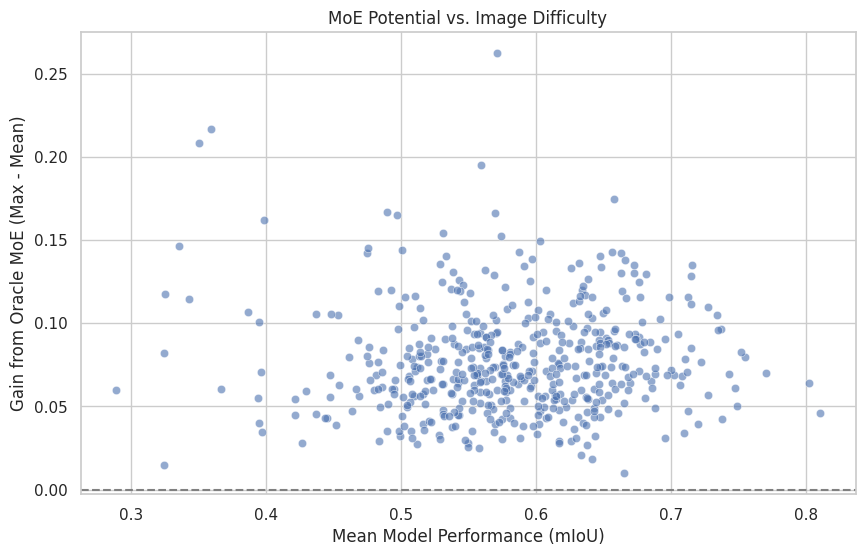

In [3]:
# --- Step 2: Global Analysis (Easy vs Hard Images) ---

# We want to analyze performance per image across all models.
# First, let's calculate the Mean IoU (mIoU) for each image/model row.
# We exclude 'image_id', 'city', 'model' columns.
class_cols = [c for c in df_all.columns if c not in ['image_id', 'city', 'model']]

# Calculate mIoU per row (per image per model)
# Note: We skip NaNs (classes not present in the image)
df_all['image_mIoU'] = df_all[class_cols].mean(axis=1)

# Pivot to have models as columns
# Index: image_id
# Columns: model names
# Values: image_mIoU
model_pivot = df_all.pivot(index='image_id', columns='model', values='image_mIoU')

# Calculate Statistics
model_pivot['mean_performance'] = model_pivot.mean(axis=1)
model_pivot['max_performance'] = model_pivot.max(axis=1) # Oracle MoE
model_pivot['difficulty'] = 1.0 - model_pivot['mean_performance'] # Higher = Harder
model_pivot['moe_gain'] = model_pivot['max_performance'] - model_pivot['mean_performance']

print("Top 5 Hardest Images (Lowest Mean mIoU):")
display(model_pivot.sort_values('mean_performance').head(5))

print("\nTop 5 'MoE Potential' Images (High Variance/Gain):")
display(model_pivot.sort_values('moe_gain', ascending=False).head(5))

# Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(data=model_pivot, x='mean_performance', y='moe_gain', alpha=0.6)
plt.title("MoE Potential vs. Image Difficulty")
plt.xlabel("Mean Model Performance (mIoU)")
plt.ylabel("Gain from Oracle MoE (Max - Mean)")
plt.axhline(0, color='grey', linestyle='--')
plt.show()

--- Analysis for Class: road ---
Total images containing road: 500
Average IoU across all images/models: 0.9390

Top 3 Hardest Images (Lowest IoU):


model,mean_iou,DDRNet,Mask2Former,SAM3-solo,SegFormer,SegFormerOHEM,SegFormerSAM3
image_id,,,,,,,
munster_000148_000019,0.0,0.0,0.0,0.0,0.0,0.0,0.0
munster_000133_000019,0.0,0.0,0.0,NaN,0.0,0.0,0.0
lindau_000049_000019,0.0,0.0,0.0,0.0,NaN,NaN,0.0
lindau_000017_000019,0.0,0.0,0.0,NaN,0.0,0.0,0.0
lindau_000035_000019,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Top 3 High Potential Images (Disagreement):


model,gain,max_iou,mean_iou
image_id,,,
frankfurt_000001_017459,0.280460,0.955838,0.675377
lindau_000023_000019,0.215081,0.976289,0.761208
munster_000173_000019,0.186070,0.973999,0.787929
munster_000141_000019,0.177483,0.969287,0.791804
munster_000145_000019,0.176278,0.992557,0.816279


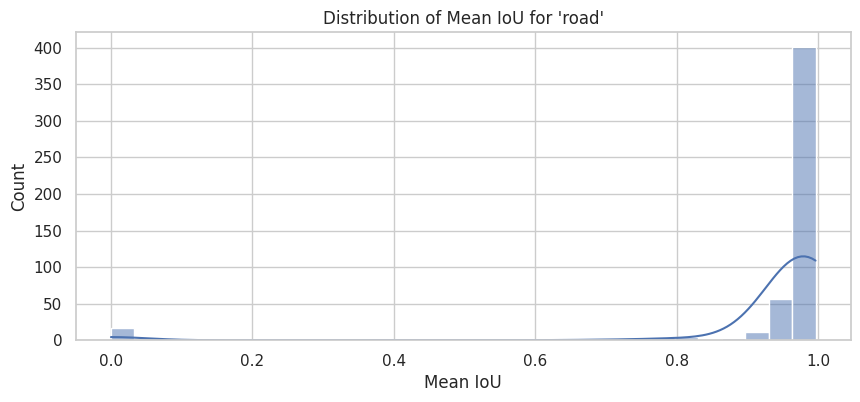

--- Analysis for Class: person ---
Total images containing person: 486
Average IoU across all images/models: 0.4418

Top 3 Hardest Images (Lowest IoU):


model,mean_iou,DDRNet,Mask2Former,SAM3-solo,SegFormer,SegFormerOHEM,SegFormerSAM3
image_id,,,,,,,
munster_000173_000019,0.0,0.0,0.0,NaN,0.0,NaN,NaN
frankfurt_000000_000576,0.0,0.0,NaN,0.0,0.0,0.0,0.0
frankfurt_000000_016286,0.0,0.0,0.0,0.0,0.0,0.0,0.0
frankfurt_000000_018797,0.0,0.0,0.0,0.0,0.0,0.0,0.0
frankfurt_000000_003357,0.0,NaN,0.0,NaN,NaN,NaN,NaN



Top 3 High Potential Images (Disagreement):


model,gain,max_iou,mean_iou
image_id,,,
lindau_000051_000019,0.620002,0.793140,0.173139
frankfurt_000000_015676,0.566037,0.729409,0.163372
lindau_000010_000019,0.503329,0.619608,0.116279
lindau_000046_000019,0.500343,0.684383,0.184040
munster_000084_000019,0.472763,0.841802,0.369039


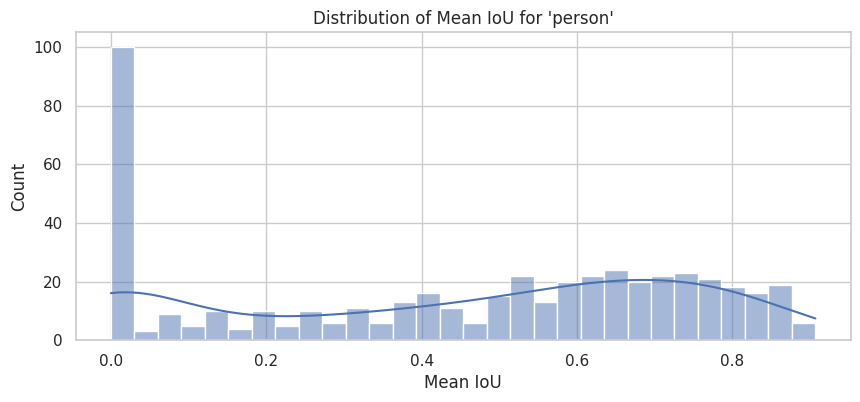

--- Analysis for Class: traffic sign ---
Total images containing traffic sign: 496
Average IoU across all images/models: 0.5900

Top 3 Hardest Images (Lowest IoU):


model,mean_iou,DDRNet,Mask2Former,SAM3-solo,SegFormer,SegFormerOHEM,SegFormerSAM3
image_id,,,,,,,
munster_000073_000019,0.0,0.0,0.0,NaN,NaN,0.0,0.0
frankfurt_000001_004327,0.0,NaN,0.0,NaN,NaN,0.0,NaN
munster_000075_000019,0.0,NaN,0.0,NaN,0.0,0.0,NaN
munster_000074_000019,0.0,0.0,0.0,NaN,NaN,0.0,0.0
munster_000021_000019,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Top 3 High Potential Images (Disagreement):


model,gain,max_iou,mean_iou
image_id,,,
munster_000034_000019,0.489181,0.952558,0.463377
frankfurt_000001_067735,0.408955,0.490746,0.081791
frankfurt_000001_061682,0.397379,0.515536,0.118157
lindau_000043_000019,0.391897,0.597368,0.205472
frankfurt_000001_060545,0.377222,0.547475,0.170252


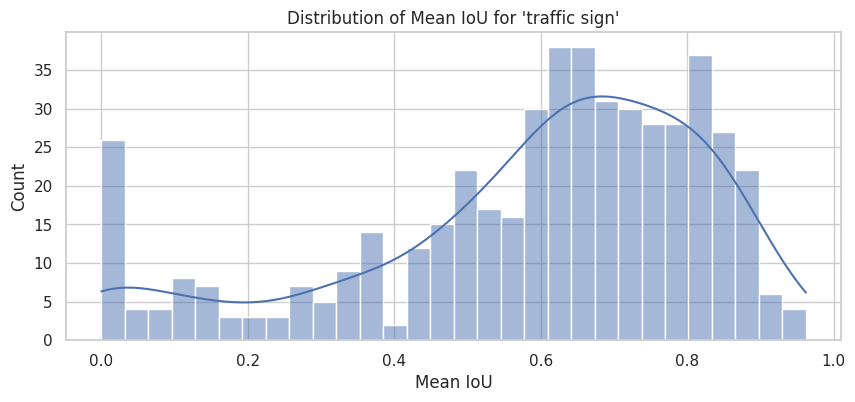

In [4]:
def analyze_class_difficulty(df_all, class_name):
    if class_name not in df_all.columns:
        print(f"Class '{class_name}' not found in data.")
        return

    # Filter data for this class
    # We only care about images where this class is present (not NaN)
    class_df = df_all[['image_id', 'model', class_name]].dropna()

    if class_df.empty:
        print(f"No valid data for class '{class_name}'")
        return

    # Pivot: Index=image_id, Cols=models, Val=IoU for this class
    pivot = class_df.pivot(index='image_id', columns='model', values=class_name)

    # Stats
    pivot['mean_iou'] = pivot.mean(axis=1)
    pivot['max_iou'] = pivot.max(axis=1)
    pivot['gain'] = pivot['max_iou'] - pivot['mean_iou']

    # Identify Hardest Images for this class
    hardest = pivot.sort_values('mean_iou').head(5)

    # Identify High Potential Images
    potential = pivot.sort_values('gain', ascending=False).head(5)

    print(f"--- Analysis for Class: {class_name} ---")
    print(f"Total images containing {class_name}: {len(pivot)}")
    print(f"Average IoU across all images/models: {pivot['mean_iou'].mean():.4f}")

    print("\nTop 3 Hardest Images (Lowest IoU):")
    display(hardest[['mean_iou'] + [c for c in pivot.columns if c not in ['mean_iou', 'max_iou', 'gain']]])

    print("\nTop 3 High Potential Images (Disagreement):")
    display(potential[['gain', 'max_iou', 'mean_iou']])

    # Plot distribution
    plt.figure(figsize=(10, 4))
    sns.histplot(pivot['mean_iou'], bins=30, kde=True)
    plt.title(f"Distribution of Mean IoU for '{class_name}'")
    plt.xlabel("Mean IoU")
    plt.show()

# Example usage:
# You can loop through classes or pick specific ones
analyze_class_difficulty(df_all, "road")
analyze_class_difficulty(df_all, "person")
analyze_class_difficulty(df_all, "traffic sign")

Frequency of 'Complete Failures' (IoU=0) vs 'Not Present' (NaN):


,Class,Total Images,NaN (Not Present),Zeros (Complete Failure),Zero Rate (of Valid)
14,truck,3000,2193,520,0.644362
17,motorcycle,3000,2225,465,0.600000
16,train,3000,2817,107,0.584699
3,wall,3000,1258,1013,0.581515
4,fence,3000,1130,1014,0.542246
9,terrain,3000,1201,830,0.461367
15,bus,3000,2411,234,0.397284
12,rider,3000,1301,598,0.351972
6,traffic light,3000,983,534,0.264750
18,bicycle,3000,721,487,0.213690


/tmp/ipython-input-1072303430.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stats_df, x='Class', y='Zero Rate (of Valid)', palette='viridis')


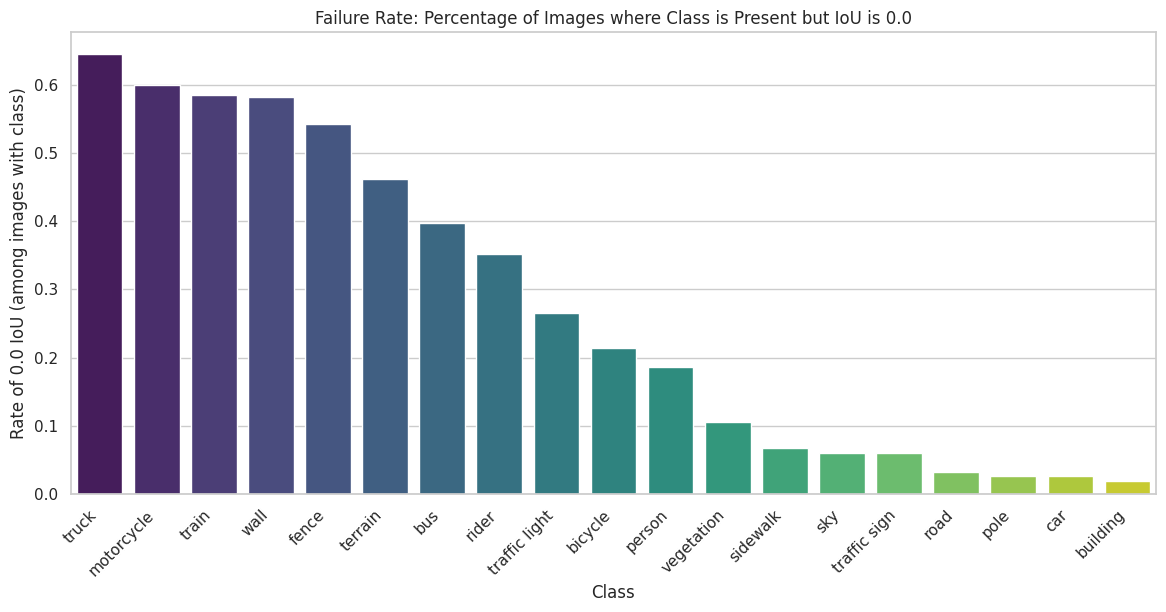

In [5]:
# It is crucial to distinguish between:
# - NaN: Class was NOT present in the image (Union = 0). Correctly ignored in mean calculation.
# - 0.0: Class WAS present (Union > 0) but Intersection was 0. This is a "Complete Failure".

# Let's check the frequency of 0.0 vs NaN for each class
analysis_stats = []

for col in class_cols:
    total = len(df_all)
    nans = df_all[col].isna().sum()
    zeros = (df_all[col] == 0).sum()
    valid_scores = total - nans

    analysis_stats.append({
        'Class': col,
        'Total Images': total,
        'NaN (Not Present)': nans,
        'Zeros (Complete Failure)': zeros,
        'Zero Rate (of Valid)': zeros / valid_scores if valid_scores > 0 else 0
    })

stats_df = pd.DataFrame(analysis_stats).sort_values('Zero Rate (of Valid)', ascending=False)

print("Frequency of 'Complete Failures' (IoU=0) vs 'Not Present' (NaN):")
display(stats_df)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=stats_df, x='Class', y='Zero Rate (of Valid)', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Failure Rate: Percentage of Images where Class is Present but IoU is 0.0")
plt.ylabel("Rate of 0.0 IoU (among images with class)")
plt.show()

In [6]:
# If using Jupyter/Colab, we can make a simple dropdown

try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output

    class_dropdown = widgets.Dropdown(
        options=sorted(class_cols),
        value='road',
        description='Class:',
    )

    output = widgets.Output()

    def on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            with output:
                clear_output()
                analyze_class_difficulty(df_all, change['new'])

    class_dropdown.observe(on_change)

    print("Select a class to analyze:")
    display(class_dropdown)
    display(output)

    # Trigger initial display
    with output:
        analyze_class_difficulty(df_all, 'road')

except ImportError:
    print("ipywidgets not installed, skipping interactive part.")

Select a class to analyze:


Dropdown(description='Class:', index=9, options=('bicycle', 'building', 'bus', 'car', 'fence', 'motorcycle', '…

Output()

In [7]:
# Visualize the distribution of IoU scores for each model to compare their spread and peaks.

try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt
    import seaborn as sns

    def ridgeline_dashboard(df):
        # Data Prep
        # Exclude metadata columns to find class columns
        meta_cols = ['image_id', 'city', 'model', 'image_mIoU']
        available_classes = sorted([c for c in df.columns if c not in meta_cols])

        # Widgets
        style = {'description_width': 'initial'}

        class_selector = widgets.Dropdown(
            options=['Total (mIoU)'] + available_classes,
            value='Total (mIoU)',
            description='Analysis Target:',
            style=style
        )

        plot_type_selector = widgets.Dropdown(
            options=['Ridgeline Plot', 'Box Plot'],
            value='Ridgeline Plot',
            description='Plot Type:',
            style=style
        )

        out_plot = widgets.Output()

        def update_plot(*args):
            target = class_selector.value
            plot_type = plot_type_selector.value

            # Filter Data
            metric = 'image_mIoU' if target == 'Total (mIoU)' else target

            if target == 'Total (mIoU)':
                plot_df = df[['model', metric]].copy()
            else:
                # Drop NaNs for specific class analysis
                plot_df = df[['model', metric]].dropna()

            # Rename for clearer plotting
            plot_df.columns = ['Model', 'IoU']

            # Sort models to ensure consistent order
            # models = [model.replace("Wrapper", "") for model in sorted(plot_df['Model'].unique())]
            models = sorted(plot_df['Model'].unique())

            with out_plot:
                clear_output()

                if plot_df.empty:
                    print("No data available for this selection.")
                    return

                if plot_type == 'Ridgeline Plot':
                    # Setup the FacetGrid for Ridgeline effect
                    # We use a transparent background for the axes so they can overlap
                    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

                    # Initialize the FacetGrid object
                    # aspect=10 makes them wide, height=0.8 controls row height
                    g = sns.FacetGrid(plot_df, row="Model", hue="Model", aspect=10, height=0.8,
                                      palette="viridis", row_order=models, hue_order=models)

                    # Smooth density curve
                    # clip_on=False allows the curve to go outside the axes (overlap)
                    # g.map(sns.kdeplot, "IoU",
                    #       clip_on=False,
                    #       fill=True, alpha=0.7, linewidth=1.5)
                    # Add a white outline for better separation
                    # g.map(sns.kdeplot, "IoU", clip_on=False, color="w", lw=2)

                    # Sharper histogram plot
                    g.map(
                      sns.histplot,
                      "IoU",
                      bins=30,
                      element="poly",   # polygon shape like a ridge
                      fill=True,
                      alpha=0.7,
                      stat="density"    # keeps comparable scale
                    )


                    # Add a horizontal line at y=0
                    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

                    # Define and use a simple function to label the plot in axes coordinates
                    def label(x, color, label):
                        ax = plt.gca()
                        ax.text(0, 0.2, label, fontweight="bold", color=color,
                                ha="left", va="center", transform=ax.transAxes)

                    g.map(label, "IoU")

                    # Set the subplots to overlap
                    g.figure.subplots_adjust(hspace=-0.5)

                    # Remove axes details that don't play well with overlap
                    g.set_titles("")
                    g.set(yticks=[], ylabel="")
                    g.despine(bottom=True, left=True)

                    # Set X-axis limits and label
                    plt.xlim(0, 1)
                    plt.xlabel("IoU Score")

                    # Add title
                    plt.suptitle(f"IoU Distribution by Model: {target}", y=0.98, fontsize=14)

                    plt.show()

                    # Reset theme for other plots in the notebook
                    sns.set_theme(style="whitegrid")

                elif plot_type == 'Box Plot':
                    plt.figure(figsize=(12, 6))
                    sns.boxplot(data=plot_df, x='IoU', y='Model', palette="viridis", order=models)
                    plt.title(f"IoU Distribution by Model (Box Plot): {target}")
                    plt.xlabel("IoU Score")
                    plt.ylabel("Model")
                    plt.xlim(0, 1)
                    plt.grid(True, axis='x', alpha=0.3)
                    plt.show()

        class_selector.observe(update_plot, names='value')
        plot_type_selector.observe(update_plot, names='value')

        display(widgets.VBox([
            widgets.HBox([class_selector, plot_type_selector]),
            out_plot
        ]))
        update_plot()

    print("Initializing Distribution Dashboard...")
    ridgeline_dashboard(df_all)

except ImportError:
    print("Required libraries not found.")

Initializing Distribution Dashboard...


In [8]:
# 1. Easy vs Hard images (Consensus across models) - Now with Image Visualization
# 2. Pairwise Model Comparison (Scatter Plot)
# 3. Overlap Analysis (Venn Diagram of Success/Failure)

try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt
    import seaborn as sns
    from PIL import Image
    import io

    # Try importing matplotlib_venn, handle if missing
    try:
        from matplotlib_venn import venn2
        HAS_VENN = True
    except ImportError:
        HAS_VENN = False
        print("Note: 'matplotlib_venn' is not installed. Venn diagrams will be disabled (text stats only).")
        print("To install: !pip install matplotlib-venn")

    def advanced_analysis_dashboard(df):
        # --- Data Prep ---
        # Identify available classes and models
        # Exclude metadata columns to find class columns
        meta_cols = ['image_id', 'city', 'model', 'image_mIoU']
        available_classes = sorted([c for c in df.columns if c not in meta_cols])
        available_models = sorted(df['model'].unique())

        if not available_models:
            print("No models found in dataframe.")
            return

        # --- Widgets ---

        # 1. Global Settings
        style = {'description_width': 'initial'}

        class_selector = widgets.Dropdown(
            options=['Total (mIoU)'] + available_classes,
            value='Total (mIoU)',
            description='Analysis Target:',
            style=style,
            layout=widgets.Layout(width='300px')
        )

        num_images_slider = widgets.IntSlider(
            value=5,
            min=2,
            max=20,
            step=1,
            description='Show N Images:',
            style=style
        )

        # 2. Comparison Settings
        model1_selector = widgets.Dropdown(
            options=available_models,
            value=available_models[0],
            description='Model A:',
            style=style
        )

        model2_selector = widgets.Dropdown(
            options=available_models,
            value=available_models[1] if len(available_models) > 1 else available_models[0],
            description='Model B:',
            style=style
        )

        # 3. Venn/Overlap Settings
        venn_mode = widgets.Dropdown(
            options=['Success (Score > T)', 'Failure (Score < T)'],
            value='Failure (Score < T)',
            description='Overlap Mode:',
            style=style
        )

        threshold_slider = widgets.FloatSlider(
            value=0.5,
            min=0.0,
            max=1.0,
            step=0.05,
            description='IoU Threshold (T):',
            style=style
        )

        # --- Output Areas ---
        out_tables = widgets.Output()
        out_scatter = widgets.Output()
        out_venn = widgets.Output()

        # --- Helper: Image Gallery ---
        def display_gallery(sub_df, title_text):
            display(widgets.HTML(f"<h3>{title_text}</h3>"))

            items = []
            for img_id, row in sub_df.iterrows():
                score = row['mean_score']
                city = img_id.split('_')[0]

                # Construct potential paths based on user instructions
                # Structure: cityscapes/leftImg8bit_trainvaltest/leftImg8bit/val/city/image.png
                candidates = [
                    CITYSCAPES_ROOT / 'leftImg8bit_trainvaltest' / 'leftImg8bit' / 'val' / city / f"{img_id}_leftImg8bit.png",
                    CITYSCAPES_ROOT / 'leftImg8bit' / 'val' / city / f"{img_id}_leftImg8bit.png",
                    CITYSCAPES_ROOT / 'val' / city / f"{img_id}_leftImg8bit.png",
                    CITYSCAPES_ROOT / 'val' / f"{img_id}_leftImg8bit.png"
                ]

                img_widget = None
                found_path = None

                for p in candidates:
                    if p.exists():
                        found_path = p
                        break

                if found_path:
                    try:
                        with Image.open(found_path) as img:
                            img.thumbnail((300, 200)) # Resize for thumbnail
                            b = io.BytesIO()
                            img.save(b, format='PNG')
                            img_widget = widgets.Image(value=b.getvalue(), format='png', width=300)
                    except Exception as e:
                        img_widget = widgets.HTML(f"Error loading image: {e}")
                else:
                    img_widget = widgets.HTML(f"<div style='width:300px;height:150px;background:#eee;display:flex;align-items:center;justify-content:center;color:#777;'>Image Not Found<br>{img_id}</div>")

                # Info Label
                info = widgets.HTML(f"<b>{img_id}</b><br>Score: {score:.3f}")

                # Card
                card = widgets.VBox([img_widget, info], layout=widgets.Layout(margin='10px', border='1px solid #ddd', padding='5px'))
                items.append(card)

            # Display grid
            display(widgets.HBox(items, layout=widgets.Layout(flex_flow='row wrap')))

        # --- Update Logic ---
        def update_dashboard(*args):
            # Get current values
            selected_target = class_selector.value
            n_images = num_images_slider.value
            m1 = model1_selector.value
            m2 = model2_selector.value
            v_mode = venn_mode.value
            thresh = threshold_slider.value

            # Determine which column to analyze
            metric_col = 'image_mIoU' if selected_target == 'Total (mIoU)' else selected_target

            # Prepare Data
            if selected_target == 'Total (mIoU)':
                sub_df = df
            else:
                sub_df = df.dropna(subset=[selected_target])

            # Pivot: Index=image_id, Columns=model, Values=score
            pivot = sub_df.pivot(index='image_id', columns='model', values=metric_col)

            # --- Tab 1: Easy vs Hard (Consensus) ---
            with out_tables:
                clear_output()

                # Calculate consensus stats
                pivot['mean_score'] = pivot.mean(axis=1)

                # Sort
                easy_df = pivot.sort_values('mean_score', ascending=False).head(n_images)
                hard_df = pivot.sort_values('mean_score', ascending=True).head(n_images)

                print(f"Analysis Target: {selected_target}")
                display_gallery(easy_df, f"TOP {n_images} EASIEST (Highest Consensus)")
                display(widgets.HTML("<hr>"))
                display_gallery(hard_df, f"TOP {n_images} HARDEST (Lowest Consensus)")

            # --- Tab 2: Scatter Plot ---
            with out_scatter:
                clear_output()
                if m1 in pivot.columns and m2 in pivot.columns:
                    plt.figure(figsize=(8, 6))

                    x_vals = pivot[m1]
                    y_vals = pivot[m2]

                    sns.scatterplot(x=x_vals, y=y_vals, alpha=0.6)
                    plt.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Identity (x=y)')

                    plt.title(f"Model Comparison: {m1} vs {m2}\nTarget: {selected_target}")
                    plt.xlabel(f"{m1} IoU")
                    plt.ylabel(f"{m2} IoU")
                    plt.xlim(-0.05, 1.05)
                    plt.ylim(-0.05, 1.05)
                    plt.legend()
                    plt.grid(True, alpha=0.3)
                    plt.show()
                else:
                    print("Selected models not found in data for this class.")

            # --- Tab 3: Venn Diagram ---
            with out_venn:
                clear_output()
                if m1 in pivot.columns and m2 in pivot.columns:
                    if 'Success' in v_mode:
                        set1 = set(pivot[pivot[m1] > thresh].index)
                        set2 = set(pivot[pivot[m2] > thresh].index)
                        title_prefix = f"Success (> {thresh})"
                    else:
                        set1 = set(pivot[pivot[m1] < thresh].index)
                        set2 = set(pivot[pivot[m2] < thresh].index)
                        title_prefix = f"Failure (< {thresh})"

                    intersection = len(set1.intersection(set2))
                    union = len(set1.union(set2))
                    jaccard = intersection / union if union > 0 else 0

                    print(f"--- Overlap Statistics ({title_prefix}) ---")
                    print(f"{m1} count: {len(set1)}")
                    print(f"{m2} count: {len(set2)}")
                    print(f"Intersection (Both): {intersection}")
                    print(f"Union (Either): {union}")
                    print(f"Jaccard Similarity: {jaccard:.2%}")

                    if HAS_VENN:
                        plt.figure(figsize=(6, 6))
                        venn2([set1, set2], set_labels=(m1, m2))
                        plt.title(f"Overlap of {title_prefix}\nTarget: {selected_target}")
                        plt.show()
                    else:
                        print("\n(Install 'matplotlib-venn' to see the diagram)")

        # --- Layout Construction ---
        class_selector.observe(update_dashboard, names='value')
        num_images_slider.observe(update_dashboard, names='value')
        model1_selector.observe(update_dashboard, names='value')
        model2_selector.observe(update_dashboard, names='value')
        venn_mode.observe(update_dashboard, names='value')
        threshold_slider.observe(update_dashboard, names='value')

        tab = widgets.Tab(children=[out_tables, out_scatter, out_venn])
        tab.set_title(0, 'Easy/Hard Gallery')
        tab.set_title(1, 'Scatter Comparison')
        tab.set_title(2, 'Overlap (Venn)')

        controls = widgets.VBox([
            widgets.HTML("<b>Global Settings:</b>"),
            widgets.HBox([class_selector, num_images_slider]),
            widgets.HTML("<hr><b>Comparison & Overlap Settings:</b>"),
            widgets.HBox([model1_selector, model2_selector]),
            widgets.HBox([venn_mode, threshold_slider]),
        ])

        dashboard = widgets.VBox([controls, tab])
        display(dashboard)

        update_dashboard()

    print("Initializing Dashboard...")
    advanced_analysis_dashboard(df_all)

except ImportError:
    print("ipywidgets or other dependencies not installed. Please install them to use the interactive dashboard.")

Initializing Dashboard...


In [9]:
# --- Step 6: Multi-Model Consensus & Divergence ---
# Visualize overlaps in 'Good' and 'Bad' performance sets across multiple models.

try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Attempt to import venn libraries
    try:
        from matplotlib_venn import venn2, venn3
        HAS_VENN_LIB = True
    except ImportError:
        HAS_VENN_LIB = False

    def consensus_dashboard(df):
        # Data Prep
        available_models = sorted(df['model'].unique())

        # Widgets
        style = {'description_width': 'initial'}

        model_selector = widgets.SelectMultiple(
            options=available_models,
            value=available_models[:3] if len(available_models) >= 3 else available_models,
            description='Select Models (2-3 for Venn):',
            style=style,
            layout=widgets.Layout(height='100px', width='300px')
        )

        good_thresh = widgets.FloatSlider(
            value=0.75, min=0.5, max=1.0, step=0.05,
            description='Good IoU Threshold (>):', style=style
        )

        bad_thresh = widgets.FloatSlider(
            value=0.4, min=0.0, max=0.5, step=0.05,
            description='Bad IoU Threshold (<):', style=style
        )

        class_selector = widgets.Dropdown(
            options=['Total (mIoU)'] + sorted([c for c in df.columns if c not in ['image_id', 'city', 'model', 'image_mIoU']]),
            value='Total (mIoU)',
            description='Class:',
            style=style
        )

        out_plot = widgets.Output()

        def update_plot(*args):
            selected_models = list(model_selector.value)
            g_thresh = good_thresh.value
            b_thresh = bad_thresh.value
            target = class_selector.value

            if not selected_models:
                with out_plot:
                    clear_output()
                    print("Please select at least one model.")
                return

            # Filter Data
            metric = 'image_mIoU' if target == 'Total (mIoU)' else target
            if target != 'Total (mIoU)':
                sub_df = df.dropna(subset=[target])
            else:
                sub_df = df

            pivot = sub_df.pivot(index='image_id', columns='model', values=metric)

            # Create Sets
            good_sets = {}
            bad_sets = {}

            for m in selected_models:
                if m in pivot.columns:
                    good_sets[m] = set(pivot[pivot[m] > g_thresh].index)
                    bad_sets[m] = set(pivot[pivot[m] < b_thresh].index)

            with out_plot:
                clear_output()

                # Layout: 2 columns (Good Overlap, Bad Overlap)
                fig, axes = plt.subplots(1, 2, figsize=(16, 7))

                # --- Plot 1: Good Overlap ---
                ax = axes[0]
                ax.set_title(f"Shared Success (IoU > {g_thresh})")

                if len(selected_models) <= 3 and HAS_VENN_LIB:
                    if len(selected_models) == 2:
                        venn2([good_sets[m] for m in selected_models], set_labels=selected_models, ax=ax)
                    elif len(selected_models) == 3:
                        venn3([good_sets[m] for m in selected_models], set_labels=selected_models, ax=ax)
                    else:
                        ax.text(0.5, 0.5, "Select 2 or 3 models for Venn", ha='center')
                else:
                    # Fallback: Bar chart of intersection sizes
                    counts = [len(s) for s in good_sets.values()]
                    sns.barplot(x=list(good_sets.keys()), y=counts, ax=ax, palette="Greens")
                    ax.set_ylabel("Count of 'Good' Images")

                    # Calculate full intersection
                    if good_sets:
                        intersection = set.intersection(*good_sets.values())
                        ax.text(0.5, 0.9, f"Intersection (All Agree): {len(intersection)}",
                                transform=ax.transAxes, ha='center', fontsize=12,
                                bbox=dict(facecolor='white', alpha=0.8))

                # --- Plot 2: Bad Overlap ---
                ax = axes[1]
                ax.set_title(f"Shared Failure (IoU < {b_thresh})")

                if len(selected_models) <= 3 and HAS_VENN_LIB:
                    if len(selected_models) == 2:
                        venn2([bad_sets[m] for m in selected_models], set_labels=selected_models, ax=ax)
                    elif len(selected_models) == 3:
                        venn3([bad_sets[m] for m in selected_models], set_labels=selected_models, ax=ax)
                    else:
                        ax.text(0.5, 0.5, "Select 2 or 3 models for Venn", ha='center')
                else:
                    counts = [len(s) for s in bad_sets.values()]
                    sns.barplot(x=list(bad_sets.keys()), y=counts, ax=ax, palette="Reds")
                    ax.set_ylabel("Count of 'Bad' Images")

                    if bad_sets:
                        intersection = set.intersection(*bad_sets.values())
                        ax.text(0.5, 0.9, f"Intersection (All Fail): {len(intersection)}",
                                transform=ax.transAxes, ha='center', fontsize=12,
                                bbox=dict(facecolor='white', alpha=0.8))

                plt.tight_layout()
                plt.show()

                # --- Text Stats ---
                print(f"--- Consensus Statistics ({target}) ---")
                if good_sets:
                    all_good = len(set.intersection(*good_sets.values()))
                    any_good = len(set.union(*good_sets.values()))
                    print(f"Images where ALL models are Good (> {g_thresh}): {all_good}")
                    print(f"Images where AT LEAST ONE model is Good: {any_good}")

                if bad_sets:
                    all_bad = len(set.intersection(*bad_sets.values()))
                    any_bad = len(set.union(*bad_sets.values()))
                    print(f"Images where ALL models are Bad (< {b_thresh}): {all_bad}")
                    print(f"Images where AT LEAST ONE model is Bad: {any_bad}")

        # Observers
        model_selector.observe(update_plot, names='value')
        good_thresh.observe(update_plot, names='value')
        bad_thresh.observe(update_plot, names='value')
        class_selector.observe(update_plot, names='value')

        # Layout
        ui = widgets.VBox([
            widgets.HTML("<h3>Multi-Model Consensus Analysis</h3>"),
            widgets.HBox([class_selector, model_selector]),
            widgets.HBox([good_thresh, bad_thresh]),
            out_plot
        ])

        display(ui)
        update_plot()

    consensus_dashboard(df_all)

except ImportError:
    print("Required libraries not found.")